# GIAB Nanopore Quality Control

Runs per-sample QC on Oxford Nanopore data generated for the genome in a bottle consortium. Requires reads to have been basecalled and aligned to the reference genome using the included pipeline.

In [34]:
import datetime
print("Ran on: ", datetime.datetime.today().strftime("%b %d, %Y at %I:%M %p"))

Ran on:  Jun 05, 2018 at 02:42 PM


## Pre-processing
Load metadata, load fastq and bam statistics, combine statistics...

In [35]:
import collections
import numpy
import os
import pandas
import sys
import tqdm

from biorpy import r, iimage

sys.path.append("/oak/stanford/groups/msalit/nspies/code/nanopore_qc/")
import experiments
import qc

In [36]:
import importlib
_ = importlib.reload(qc)

In [37]:
metadata = experiments.load_experiment_metadata()

In [38]:
fastq_results = {}

for flowcell_label, flowcell_info in list(metadata.items()):
    results = []
    for run_info in flowcell_info["datasets"]:
        run_label = run_info["name"]
        for fastq in qc.fastq_paths(flowcell_label, run_label):
            results.append(qc.get_fastq_stats(fastq))
        
        if len(results) > 0:
            cur_results = pandas.concat(results).set_index("read_id")
            if cur_results.index.duplicated().any():
                print(f"WARNING: duplicated reads exist in fastq for run {run_info['name']}!")
            cur_results = cur_results.loc[~cur_results.index.duplicated()]
            fastq_results[run_label] = cur_results
        else:
            print(f"WARNING: run fastq is apparently empty: {run_label}")

In [39]:
warnings = []

bam_results = collections.OrderedDict()
for i, (flowcell_label, flowcell_info) in list(enumerate(metadata.items())):
#     print(f"{i+1} of {len(metadata)} {flowcell_label}")
    results = []
    for run_info in flowcell_info["datasets"]:
        run_label = run_info["name"]

        path = qc.bam_path(run_label)
        if not os.path.exists(path):
            warnings.append(f"WARNING: skipping {run_label} (no bam/cram file found)...")
            continue
        cur_result = qc.get_bam_stats(path)
        cur_result["flowcell_id"] = flowcell_label
        cur_result["sample"] = run_info["sample"]
        bam_results[run_label] = cur_result
        
for warning in warnings: print(warning)

In [40]:
combined_results = []

for run_id in bam_results:
    cur_df = pandas.merge(fastq_results[run_id], bam_results[run_id],
                          left_index=True, right_index=True)
    cur_df["run_label"] = run_id
    combined_results.append(cur_df)
    
combined_results = pandas.concat(combined_results)

combined_results["run_id"] = combined_results["run_id"].astype("category")
combined_results["run_label"] = combined_results["flowcell_id"] + "-" + \
                                combined_results["sample"].fillna(combined_results["run_label"])
combined_results["run_label"] = combined_results["run_label"].astype("category")
combined_results["flowcell_id"] = combined_results["flowcell_id"].astype("category")
combined_results["date"] = pandas.to_datetime(combined_results["date"])

## Plot read length vs coverage

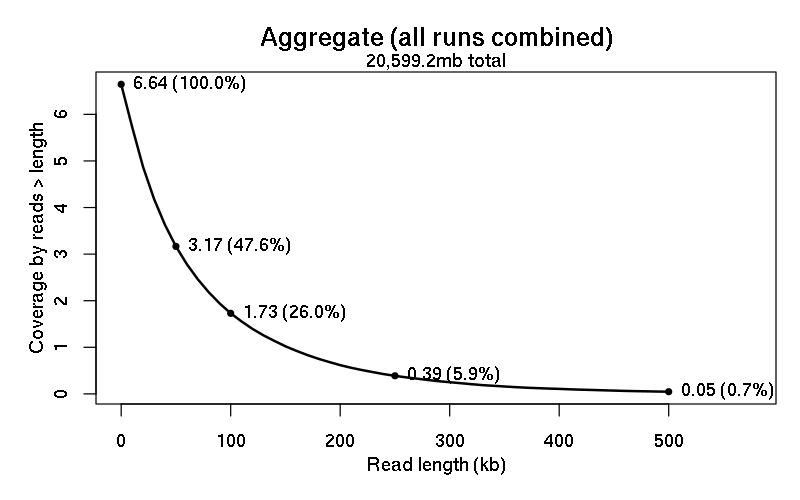

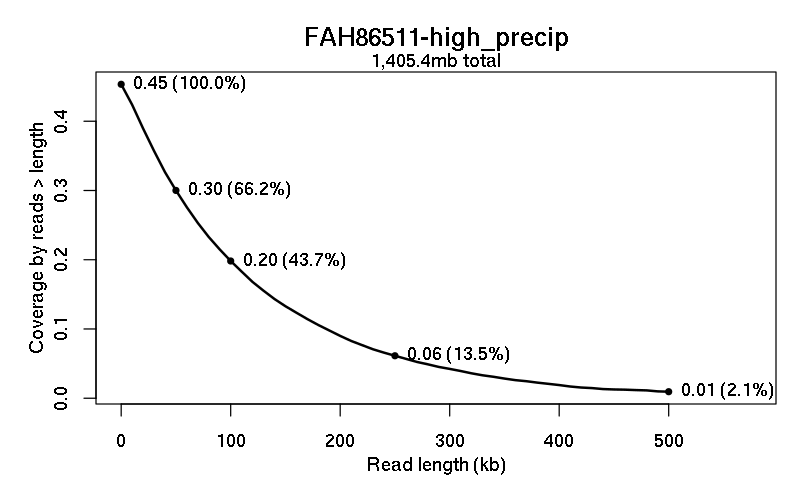

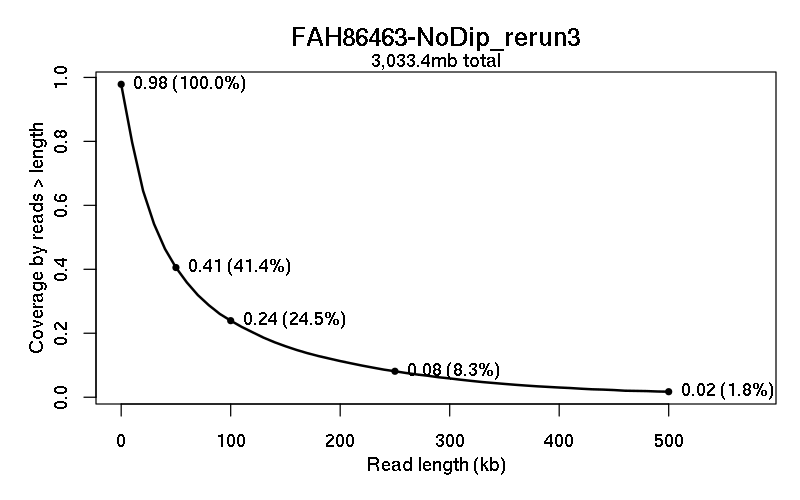

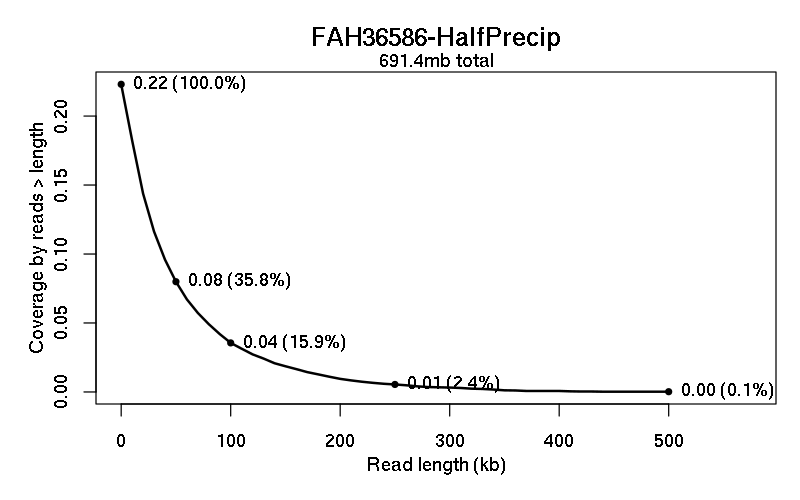

In [41]:
iimage.start(format="png", res=120, width=800, height=500)
r.par(mar=[4,4,3,1], mgp=(2,1,0))
qc.plot_coverages(combined_results["aln_lengthmax"], "Aggregate (all runs combined)")

n = 3 # most recent n runs
sorted_runs = sorted(combined_results.groupby("run_label", sort=False), 
                key=lambda x:x[1].date.min(), reverse=True)
for run_id, cur_results in sorted_runs[:n]:
    qc.plot_coverages(cur_results["aln_lengthmax"], run_id)

iimage.finish()

## Summary by run

Show N50 and total number of mappable bases sequenced per run.

"aln_lengthmax" is the longest single alignment for each read, as measured by its span in the read (as opposed to on the reference). For example, if bases 600-41000 (out of a 4600bp read) map to the genome, its aln_lengthmax would be 41000-600=40400. 

In [42]:
# make this a separate function so the column will be nicely named
def N50(values):
    return qc.n50(values.values)

def _format(x):
    try:
        return x.strftime("%Y-%b-%d")
    except AttributeError:
        return "{:,}".format(x)
def style(x):
    return x.style.format(_format) \
            .set_properties(**{"font-family":"courier"})

n = 10 # show only n runs
aln_length = "aln_lengthmax"
g = combined_results.groupby("run_label", sort=False)

table = g.agg({aln_length:[N50, "sum"], "date":"min"})

#### Most recent runs

In [43]:
style(table.sort_values([("date", "min")], ascending=False).iloc[:n])

#### Top longest runs

In [44]:
style(table.sort_values([(aln_length, "N50")], ascending=False).iloc[:n])

#### Best throughput

In [45]:
style(table.sort_values([(aln_length, "sum")], ascending=False).iloc[:n])

#### Overall

In [46]:
overall = combined_results.agg({"aln_lengthmax":[N50, "sum"]}).style.format(_format)
overall

,aln_lengthmax
N50,"46,397"
sum,"20,599,203,487"


#### Detailed summary of most recent runs

In [47]:
def print_summary(label, results):
    print(label)
    x = results["ref_lengthmax"]
    for i in [0, 5e4, 1e5, 2e5, 3e5, 4e5, 5e5]:
        cur = x[x>i]
        print(f"  > {int(i):>8,}bp"
              f"   n={len(cur):>10,}"
              f"   bases={cur.sum():14,.0f}"
              f"   coverage={cur.sum()/3.2e9:.2f}x")
    x = x.copy().values
    x.sort()

    print("  Top 10 reads (bp):")
    print("    " + "  ".join("{:,}".format(xx) for xx in x[-1:-11:-1]))
    print()
    
print_summary("Aggregate (all runs)", combined_results)
for run_id,cur_results in sorted_runs[:3]:
    print_summary(run_id, cur_results)

Aggregate (all runs)
  >        0bp   n= 1,390,654   bases=21,383,327,326   coverage=6.68x
  >   50,000bp   n=   101,892   bases=10,452,903,367   coverage=3.27x
  >  100,000bp   n=    34,568   bases= 5,793,902,046   coverage=1.81x
  >  200,000bp   n=     7,434   bases= 2,115,320,909   coverage=0.66x
  >  300,000bp   n=     2,200   bases=   867,638,972   coverage=0.27x
  >  400,000bp   n=       727   bases=   367,490,359   coverage=0.11x
  >  500,000bp   n=       279   bases=   169,691,363   coverage=0.05x
  Top 10 reads (bp):
    1,216,996  1,190,690  1,118,575  1,032,399  1,027,478  1,015,888  1,012,707  1,003,718  978,858  957,653

FAH86511-high_precip
  >        0bp   n=    51,701   bases= 1,433,393,313   coverage=0.45x
  >   50,000bp   n=     8,052   bases=   955,796,101   coverage=0.30x
  >  100,000bp   n=     3,477   bases=   634,940,561   coverage=0.20x
  >  200,000bp   n=       991   bases=   293,158,722   coverage=0.09x
  >  300,000bp   n=       343   bases=   137,807,649   co

## Performance over time during run

Vertical red dashed lines indicate manual run restarts. Any other peaks are likely caused by automatic advancing to a new mux group.

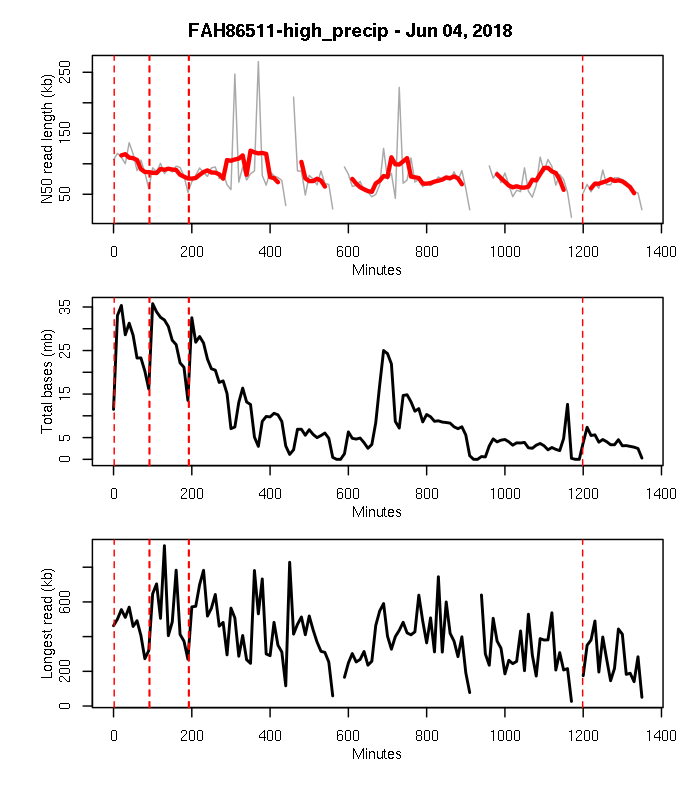

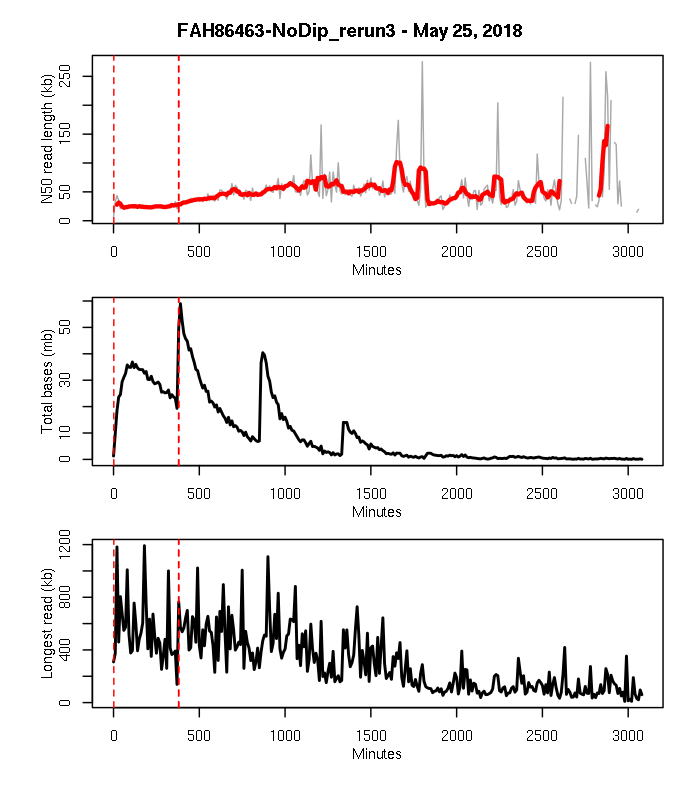

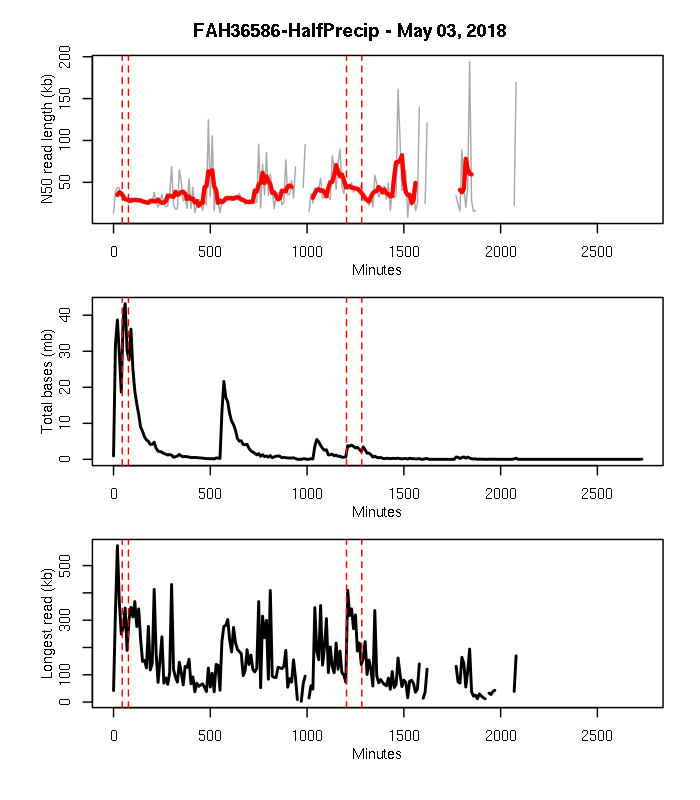

In [48]:
frequency = 10 # minutes

iimage.start(format="png", height=800, width=700, res=140)
r.par(mfcol=[3,1], mar=[3,3,1,0], oma=[2,2,2,2], mgp=[2,1,0])
n = 3
for run_id, cur_results in sorted_runs[:n]:
    y = cur_results.groupby(pandas.Grouper(freq=f"{frequency}min", key="date", convention="start"))["aln_lengthmax"]
    
    total = y.sum()
    n50s = y.agg(N50)
    maxs = y.max()
    start_time = cur_results["date"].min()
    x = (total.index - total.index[0]).total_seconds()
    
    time_label = (start_time - pandas.Timedelta('8 hours')).strftime("%b %d, %Y")
    
    r.plot(x/60, n50s/1e3, col="darkgray", type="l", xlab="Minutes", 
           ylab="N50 read length (kb)")
    r.lines(pandas.Series(x/60).rolling(5).mean(center=True), (n50s/1e3).rolling(5).mean(center=True), col="red", lwd=3)
    
    by_run = cur_results.groupby("run_id")
    starts = []
    for _,run in by_run:
        if len(run) == 0: continue
        delta = (run["date"].min() - start_time).total_seconds()
        if delta > 0:
            starts.append(delta)
    r.abline(v=numpy.array(starts)/60, col="red", lty=2)
    
    r.plot(x/60, total/1e6, lwd=2, type="l", xlab="Minutes", ylab="Total bases (mb)")
    r.abline(v=numpy.array(starts)/60, col="red", lty=2)
    
    r.plot(x/60, maxs/1e3, lwd=2, type="l", xlab="Minutes", ylab="Longest read (kb)")
    r.abline(v=numpy.array(starts)/60, col="red", lty=2)

    r.title(f"{run_id} - {time_label}", line=0, outer=True)

iimage.finish()

In [49]:
## 